## PROJETO 3 - VAE com MNIST

Este notebook documenta a parte do Projeto 3 dedicada ao uso do dataset MNIST. Nosso objetivo é aprofundar no entendimento dos Modelos Autoencoders Variacionais (VAEs) e avaliar sua eficácia em datasets rotulados. As etapas do projeto são detalhadas a seguir:

#### Seleção do Dataset
- **Dataset Escolhido**: MNIST, um dos datasets mais clássicos e amplamente utilizados em aprendizado de máquina para tarefas de classificação de imagens. Contém imagens de dígitos escritos à mão, variando de 0 a 9.

#### Treinamento do Modelo VAE
- **Construção e Ajuste do Modelo**: Construímos e afinamos um modelo VAE especificamente para o dataset MNIST.
   - **Estrutura do Modelo**: O modelo é composto por um encoder e um decoder. O encoder mapeia as entradas para o espaço latente e o decoder reconstrói as imagens a partir desse espaço.
   - **Dimensionalidade**: As imagens de dígitos foram convertidas em vetores de 784 dimensões (28x28 pixels) e a dimensão latente foi estabelecida em 20.
   - **Camadas e Ativações**: Implementamos camadas densas com ativação ReLU e utilizamos a ativação sigmóide na última camada do decoder.

#### Ajuste do Melhor Modelo
- **Função de Custo e Validação**: Empregamos a soma do erro de reconstrução (binary crossentropy) e a divergência KL como função de custo. Esta abordagem busca um equilíbrio entre a precisão da reconstrução e a regularização do espaço latente.
- **Treinamento e Validação**: O modelo foi treinado com o conjunto de dados de treino e validado com um conjunto de teste separado.

#### Exploração do Espaço Latente
- **Projeção em 2D com PCA**: Com o modelo treinado, aplicamos a Análise de Componentes Principais (PCA) para projetar o espaço latente em 2 dimensões, visando facilitar a interpretação visual dos resultados.
- **Uso dos Rótulos na Projeção**: Na projeção 2D, etiquetamos cada ponto com o rótulo correspondente do dígito, o que nos permite observar como as diferentes classes de dígitos são distribuídas no espaço latente.


---

### Análise Comparativa do Espaço Latente dos Modelos VAE para MNIST

Este notebook documenta uma análise comparativa detalhada do espaço latente resultante de dois modelos VAE diferentes treinados no dataset Fashion MNIST. Os gráficos a seguir (no notebook) representam as projeções 2D do espaço latente para o modelo inicial e o modelo otimizado.

#### Projeção 2D do Espaço Latente do Modelo Inicial
Verificar no notebook um pouco abaixo. É a primeira projeçao.

#### Projeção 2D do Espaço Latente do Modelo Otimizado
Verificar no notebook um pouco abaixo. É a segunda projeçao.

#### Formação de Clusters
- **Modelo Inicial**: Apresenta uma formação de clusters, porem sobrepostos
- **Modelo Otimizado**: Os clusters são mais sobrepostos ainda

#### Separação dos Rótulos
- **Modelo Inicial**: A separação dos rótulos é relativamente difusa, com muitas sobreposições entre as categorias.
- **Modelo Otimizado**: Observa-se uma melhoria na separação dos rótulos, com grupos mais distintos correspondendo às categorias de vestuário. Isso sugere uma representação latente mais discriminativa após a otimização.

#### Variância Capturada pela Projeção
- A projeção PCA em ambos os modelos ilustra uma parte significativa da variância. Contudo, o modelo otimizado parece capturar uma maior variância intraclasse, o que pode ser um indicativo de uma melhor representação latente dos dados.

## Análise dos Resultados do VAE no MNIST

### Qualidade da Geração de Imagens
- **Alta qualidade nas imagens geradas**: A maioria dos dígitos é claramente visível, indicando um aprendizado efetivo da distribuição latente dos dados MNIST.

### Variedade e Diversidade
- **Ampla gama de dígitos gerados**: Variações nos estilos manuscritos dos números, demonstrando boa generalização do modelo.

### Continuidade e Suavidade do Espaço Latente
- **Transições suaves entre dígitos**: Indica uma boa organização do espaço latente, com pequenas alterações nos pontos latentes resultando em mudanças incrementais nas imagens.

### Presença de Artefatos ou Anomalias
- **Ausência de artefatos significativos**: Poucas anomalias nas imagens, sugerindo uma modelagem eficaz do espaço latente.

### Comparação com o Dataset Original
- **Semelhança com as imagens originais do MNIST**: As imagens geradas se assemelham, em estilo e qualidade, às imagens originais do dataset, com variações criativas.

---

**Conclusão**: Os resultados indicam um desempenho robusto do VAE no MNIST, com uma representação eficaz e aprendizado adequado dos dados de dígitos manuscritos.

In [1]:
!pip install tensorflow optuna matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Carregando o dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizando os dados para o intervalo [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Achatar as imagens para vetores de 28*28 = 784 elementos
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

# Vamos imprimir as dimensões para verificar se está correto
print(x_train.shape, x_test.shape)


11490434/11490434 [==============================] - 1s 0us/step
(60000, 784) (10000, 784)


In [3]:
def build_vae(input_shape, latent_dim, intermediate_dims):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for intermediate_dim in intermediate_dims:
        x = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)


    # Função para amostrar do espaço latente
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = latent_inputs
    for intermediate_dim in reversed(intermediate_dims):
        x = Dense(intermediate_dim, activation='relu')(x)
    outputs = Dense(input_shape[0], activation='sigmoid')(x)

    # Decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')

    # VAE loss
    reconstruction_loss = binary_crossentropy(inputs, outputs) * input_shape[0]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return encoder, decoder, vae

# Criando o VAE
encoder, decoder, vae = build_vae((784,), latent_dim=20, intermediate_dims=[256])


# Resumo do modelo
encoder.summary()
decoder.summary()
vae.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 20)                   5140      ['dense[0][0]']               
                                                                                                  
 z_log_var (Dense)           (None, 20)                   5140      ['dense[0][0]']               
                                                                                            

In [4]:
#Treinamento VAE Simples para testar

# Parâmetros de treinamento
epochs = 15  # Pode ajustar conforme necessário
batch_size = 256  # Pode ajustar conforme necessário

# Treinamento do modelo
vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


Epoch 1/15
235/235 [==============================] - 5s 6ms/step - loss: 199.1886 - val_loss: 147.6020
Epoch 2/15
235/235 [==============================] - 1s 4ms/step - loss: 137.8189 - val_loss: 128.9592
Epoch 3/15
235/235 [==============================] - 1s 4ms/step - loss: 125.8875 - val_loss: 121.0414
Epoch 4/15
235/235 [==============================] - 1s 4ms/step - loss: 120.0997 - val_loss: 116.8305
Epoch 5/15
235/235 [==============================] - 1s 4ms/step - loss: 116.8561 - val_loss: 114.2905
Epoch 6/15
235/235 [==============================] - 1s 4ms/step - loss: 114.6636 - val_loss: 112.7851
Epoch 7/15
235/235 [==============================] - 1s 4ms/step - loss: 113.0436 - val_loss: 111.3077
Epoch 8/15
235/235 [==============================] - 1s 4ms/step - loss: 111.8557 - val_loss: 110.1098
Epoch 9/15
235/235 [==============================] - 1s 4ms/step - loss: 110.8641 - val_loss: 109.4087
Epoch 10/15
235/235 [==============================] - 1s 4ms/st

40/40 [==============================] - 0s 2ms/step


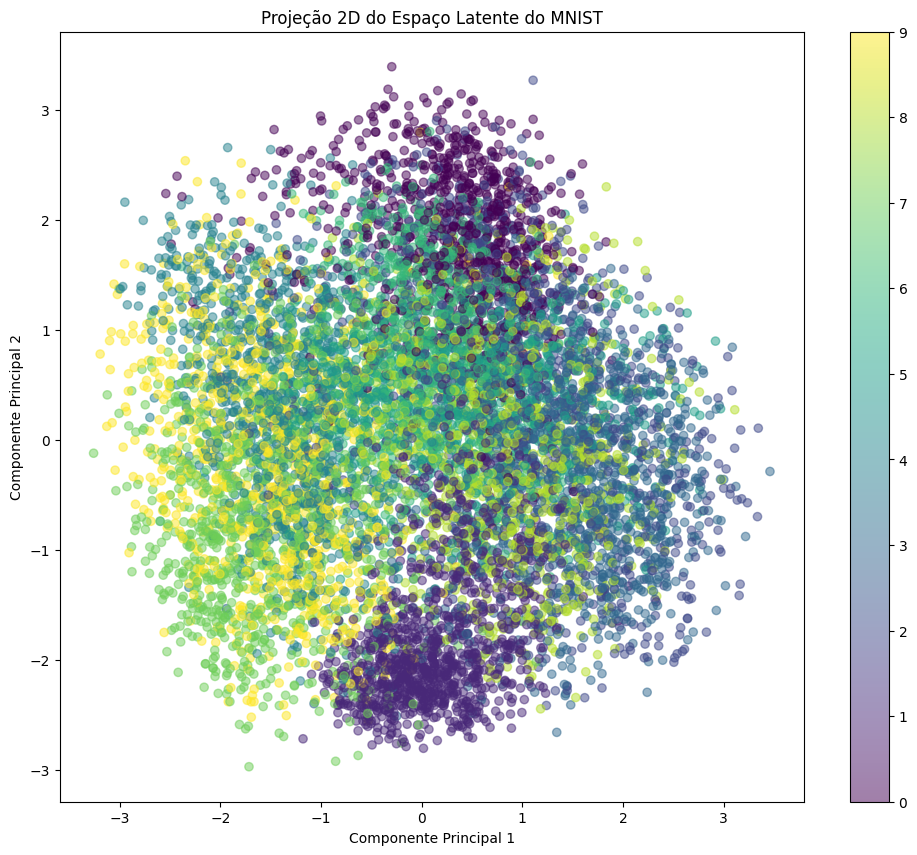

In [5]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Obtendo as representações latentes
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)

# Usando PCA para reduzir a dimensionalidade para 2D
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)

# Plotando a projeção do espaço latente
plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, alpha=0.5, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção 2D do Espaço Latente do MNIST')
plt.show()


In [9]:
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate
from tqdm.auto import tqdm

# Definindo a função de objetivo do VAE para o Optuna
def vae_objective(trial):
    # Hiperparâmetros do Optuna
    num_layers = trial.suggest_int('num_layers', 1, 4)
    latent_dim = trial.suggest_int('latent_dim', 1, 20)
    intermediate_dims = [trial.suggest_int(f'intermediate_dim_{i}', 128, 1024, log=True) for i in range(num_layers)]
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    epochs = 30  # Pode ser fixo ou também otimizado pelo Optuna

    # Construção do modelo VAE com os hiperparâmetros sugeridos
    encoder, decoder, vae = build_vae((784,), latent_dim=latent_dim, intermediate_dims=intermediate_dims)

    # Treinamento do modelo
    history = vae.fit(x_train, x_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(x_test, x_test),
                      verbose=0)  # verbose=0 para não imprimir o progresso

    # Retorna a última perda de validação
    val_loss = history.history['val_loss'][-1]
    return val_loss

# Definindo um nome para o estudo e habilitando o progress bar
study_name = 'mnist_vae_optimization'  # Nome do estudo
study = optuna.create_study(direction='minimize', study_name=study_name)

# Callback para acompanhar o progresso
def print_progress(study, trial):
    last_value = trial.value if trial.value is not None else float('nan')
    print(f"Trial {trial.number}: val_loss = {last_value:.3f}, params = {trial.params}")

# Função de progresso personalizada
def optuna_progress_bar(study, trial):
    bar.update(1)

# Inicializando o progress bar
bar = tqdm(total=10, desc=study_name)

# Otimizando com progress bar e print callback
study.optimize(vae_objective, n_trials=10, callbacks=[print_progress, optuna_progress_bar])

# Fechando o progress bar
bar.close()

# Mostrar os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {study.best_params}")




[I 2023-12-21 02:51:16,710] A new study created in memory with name: mnist_vae_optimization


mnist_vae_optimization:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-21 02:52:58,958] Trial 0 finished with value: 169.9384765625 and parameters: {'num_layers': 1, 'latent_dim': 1, 'intermediate_dim_0': 412, 'batch_size': 64}. Best is trial 0 with value: 169.9384765625.


Trial 0: val_loss = 169.938, params = {'num_layers': 1, 'latent_dim': 1, 'intermediate_dim_0': 412, 'batch_size': 64}


[I 2023-12-21 02:53:44,444] Trial 1 finished with value: 109.74467468261719 and parameters: {'num_layers': 4, 'latent_dim': 11, 'intermediate_dim_0': 394, 'intermediate_dim_1': 146, 'intermediate_dim_2': 545, 'intermediate_dim_3': 207, 'batch_size': 256}. Best is trial 1 with value: 109.74467468261719.


Trial 1: val_loss = 109.745, params = {'num_layers': 4, 'latent_dim': 11, 'intermediate_dim_0': 394, 'intermediate_dim_1': 146, 'intermediate_dim_2': 545, 'intermediate_dim_3': 207, 'batch_size': 256}


[I 2023-12-21 02:55:27,292] Trial 2 finished with value: 137.2296600341797 and parameters: {'num_layers': 1, 'latent_dim': 3, 'intermediate_dim_0': 361, 'batch_size': 64}. Best is trial 1 with value: 109.74467468261719.


Trial 2: val_loss = 137.230, params = {'num_layers': 1, 'latent_dim': 3, 'intermediate_dim_0': 361, 'batch_size': 64}


[I 2023-12-21 02:55:46,113] Trial 3 finished with value: 105.82198333740234 and parameters: {'num_layers': 1, 'latent_dim': 14, 'intermediate_dim_0': 482, 'batch_size': 512}. Best is trial 3 with value: 105.82198333740234.


Trial 3: val_loss = 105.822, params = {'num_layers': 1, 'latent_dim': 14, 'intermediate_dim_0': 482, 'batch_size': 512}


[I 2023-12-21 02:58:01,495] Trial 4 finished with value: 105.70663452148438 and parameters: {'num_layers': 3, 'latent_dim': 12, 'intermediate_dim_0': 367, 'intermediate_dim_1': 489, 'intermediate_dim_2': 552, 'batch_size': 64}. Best is trial 4 with value: 105.70663452148438.


Trial 4: val_loss = 105.707, params = {'num_layers': 3, 'latent_dim': 12, 'intermediate_dim_0': 367, 'intermediate_dim_1': 489, 'intermediate_dim_2': 552, 'batch_size': 64}


[I 2023-12-21 02:58:25,553] Trial 5 finished with value: 111.71714782714844 and parameters: {'num_layers': 3, 'latent_dim': 6, 'intermediate_dim_0': 329, 'intermediate_dim_1': 734, 'intermediate_dim_2': 146, 'batch_size': 512}. Best is trial 4 with value: 105.70663452148438.


Trial 5: val_loss = 111.717, params = {'num_layers': 3, 'latent_dim': 6, 'intermediate_dim_0': 329, 'intermediate_dim_1': 734, 'intermediate_dim_2': 146, 'batch_size': 512}


[I 2023-12-21 03:00:56,886] Trial 6 finished with value: 113.69401550292969 and parameters: {'num_layers': 4, 'latent_dim': 11, 'intermediate_dim_0': 245, 'intermediate_dim_1': 232, 'intermediate_dim_2': 990, 'intermediate_dim_3': 357, 'batch_size': 64}. Best is trial 4 with value: 105.70663452148438.


Trial 6: val_loss = 113.694, params = {'num_layers': 4, 'latent_dim': 11, 'intermediate_dim_0': 245, 'intermediate_dim_1': 232, 'intermediate_dim_2': 990, 'intermediate_dim_3': 357, 'batch_size': 64}


[I 2023-12-21 03:02:09,140] Trial 7 finished with value: 102.11746215820312 and parameters: {'num_layers': 3, 'latent_dim': 10, 'intermediate_dim_0': 565, 'intermediate_dim_1': 590, 'intermediate_dim_2': 514, 'batch_size': 128}. Best is trial 7 with value: 102.11746215820312.


Trial 7: val_loss = 102.117, params = {'num_layers': 3, 'latent_dim': 10, 'intermediate_dim_0': 565, 'intermediate_dim_1': 590, 'intermediate_dim_2': 514, 'batch_size': 128}


[I 2023-12-21 03:03:52,101] Trial 8 finished with value: 122.24610900878906 and parameters: {'num_layers': 1, 'latent_dim': 5, 'intermediate_dim_0': 283, 'batch_size': 64}. Best is trial 7 with value: 102.11746215820312.


Trial 8: val_loss = 122.246, params = {'num_layers': 1, 'latent_dim': 5, 'intermediate_dim_0': 283, 'batch_size': 64}


[I 2023-12-21 03:04:11,359] Trial 9 finished with value: 132.69497680664062 and parameters: {'num_layers': 1, 'latent_dim': 4, 'intermediate_dim_0': 368, 'batch_size': 512}. Best is trial 7 with value: 102.11746215820312.


Trial 9: val_loss = 132.695, params = {'num_layers': 1, 'latent_dim': 4, 'intermediate_dim_0': 368, 'batch_size': 512}
Melhores hiperparâmetros: {'num_layers': 3, 'latent_dim': 10, 'intermediate_dim_0': 565, 'intermediate_dim_1': 590, 'intermediate_dim_2': 514, 'batch_size': 128}


In [10]:
!nvidia-smi


Thu Dec 21 03:04:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0              29W /  70W |   8325MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
!pip install plotly

import plotly
print(plotly.__version__)


5.15.0


In [12]:
#Usando o modo offline do ploty, ja que o outro nao funcinou.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [13]:
!pip install "notebook>=5.3" "ipywidgets>=7.2"
!jupyter nbextension enable --py widgetsnbextension


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.4 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [14]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate
import plotly


# Plotando a história da otimização
fig1 = plot_optimization_history(study)
fig1.show()

# Plotando coordenadas paralelas dos hiperparâmetros
fig2 = plot_parallel_coordinate(study)
fig2.show()


In [15]:
#Salvar estudo Optune
import joblib

joblib.dump(study, 'study.pkl')


['study.pkl']

Epoch 1/15
469/469 [==============================] - 6s 6ms/step - loss: 170.6653
Epoch 2/15
469/469 [==============================] - 3s 6ms/step - loss: 128.5309
Epoch 3/15
469/469 [==============================] - 3s 6ms/step - loss: 120.2673
Epoch 4/15
469/469 [==============================] - 2s 5ms/step - loss: 114.6567
Epoch 5/15
469/469 [==============================] - 2s 5ms/step - loss: 111.7388
Epoch 6/15
469/469 [==============================] - 3s 5ms/step - loss: 109.7553
Epoch 7/15
469/469 [==============================] - 2s 5ms/step - loss: 108.3583
Epoch 8/15
469/469 [==============================] - 2s 5ms/step - loss: 107.1585
Epoch 9/15
469/469 [==============================] - 2s 5ms/step - loss: 106.2417
Epoch 10/15
469/469 [==============================] - 2s 5ms/step - loss: 105.4747
Epoch 11/15
469/469 [==============================] - 2s 5ms/step - loss: 104.7623
Epoch 12/15
469/469 [==============================] - 2s 5ms/step - loss: 104.2700
E

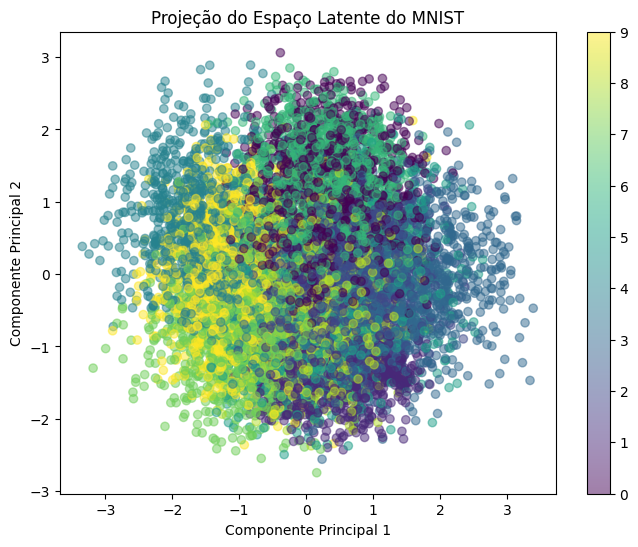

In [16]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 1. Construir o modelo VAE com os melhores hiperparâmetros
best_params = study.best_params

# Extraindo o número de camadas e as dimensões intermediárias
num_layers = best_params['num_layers']
intermediate_dims = [best_params[f'intermediate_dim_{i}'] for i in range(num_layers)]

encoder, decoder, vae = build_vae(
    input_shape=(784,),
    latent_dim=best_params['latent_dim'],
    intermediate_dims=intermediate_dims
)



# 2. Treinar modelo com o conjunto de dados completo
vae.fit(x_train, x_train, epochs=15, batch_size=best_params['batch_size'])

# 3. Projeção do espaço latente em 2D
z_mean, _, _ = encoder.predict(x_test, batch_size=best_params['batch_size'])
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)
plt.figure(figsize=(8, 6))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, alpha=0.5, cmap='viridis')
plt.colorbar()
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção do Espaço Latente do MNIST')
plt.show()




1/1 [==============================] - 0s 18ms/step


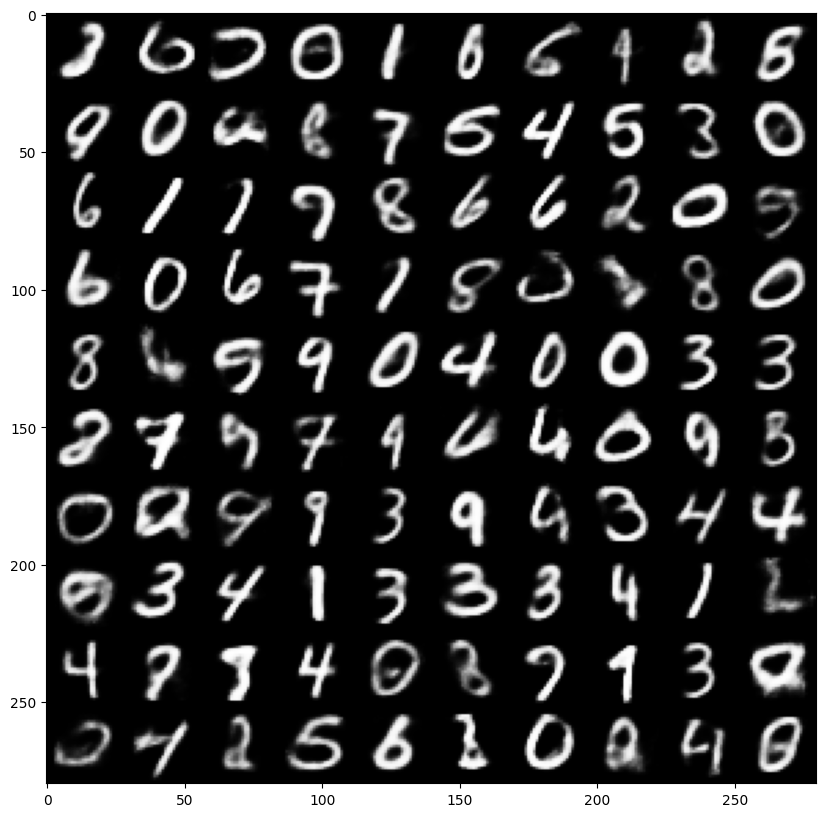

In [19]:
n = 10  # número de dígitos para gerar
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))


#latent_dim = best_params['latent_dim']
latent_dim = 10

# Amostra aleatória de pontos no espaço latente
# Assegurando que cada ponto z_sample tenha a dimensão correta
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Aqui nós criamos um vetor latente com a dimensão correta
        z_sample = np.random.normal(size=(1, latent_dim))
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.grid(False)
plt.show()


In [20]:
import joblib

# Carregar estudo do Optuna
study = joblib.load('study.pkl')
